In [277]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import backend as K

In [367]:
sales = pd.read_csv('./data/sales.csv', index_col=0)
sales.head()

,Paid at,Total,year,month,week,days,date
7698,2020-10-05 12:28:48+05:30,310.0,2020,10,41,5,2020-10-05
7692,2020-12-01 12:55:58+05:30,2600.0,2020,12,49,1,2020-12-01
7687,2020-10-11 15:01:55+05:30,1920.0,2020,10,41,11,2020-10-11
7686,2020-12-01 13:41:32+05:30,640.0,2020,12,49,1,2020-12-01
7684,2020-10-12 22:30:12+05:30,350.0,2020,10,42,12,2020-10-12


**When using the sigmoid (default) or tanh activation functions, LSTMs are sensitive to the scale of the input data. Rescaling data to the 0-to-1 range, also known as normalizing, is a recommended technique. Using the MinMaxScaler preprocessing class from the scikit-learn package, we can quickly normalize the dataset.**

In [368]:

# normalize the dataset
scaler = MinMaxScaler()
sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))

In [369]:
sales_norm

array([[0.        ],
       [0.26767972],
       [0.18819404],
       ...,
       [0.03974284],
       [0.06300409],
       [0.0314436 ]])

In [370]:
sales_norm = sales_norm.flatten().tolist()

In [371]:
sales['sales_norm'] = sales_norm

In [372]:
sales.head()

,Paid at,Total,year,month,week,days,date,sales_norm
7698,2020-10-05 12:28:48+05:30,310.0,2020,10,41,5,2020-10-05,0.000000
7692,2020-12-01 12:55:58+05:30,2600.0,2020,12,49,1,2020-12-01,0.267680
7687,2020-10-11 15:01:55+05:30,1920.0,2020,10,41,11,2020-10-11,0.188194
7686,2020-12-01 13:41:32+05:30,640.0,2020,12,49,1,2020-12-01,0.038574
7684,2020-10-12 22:30:12+05:30,350.0,2020,10,42,12,2020-10-12,0.004676


In [373]:
sales = sales.drop(['Paid at','Total','year','month','week','days','date'], axis = 1)
sales.head()

,sales_norm
7698,0.000000
7692,0.267680
7687,0.188194
7686,0.038574
7684,0.004676


In [374]:
#adding lag to the sales
for lag in range(1,31):
    col_name = 'lag_' +str(lag)
    sales[col_name] = sales['sales_norm'].shift(lag)

#drop null val
sales = sales.dropna().reset_index(drop = True)

In [375]:
sales.head()

,sales_norm,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,0.039743,0.136762,0.044418,0.078434,0.281473,0.095266,0.022209,0.089071,0.074810,0.017534,...,0.044418,0.085330,0.120397,0.155465,0.120397,0.004676,0.038574,0.188194,0.267680,0.000000
1,0.085330,0.039743,0.136762,0.044418,0.078434,0.281473,0.095266,0.022209,0.089071,0.074810,...,0.061952,0.044418,0.085330,0.120397,0.155465,0.120397,0.004676,0.038574,0.188194,0.267680
2,0.230275,0.085330,0.039743,0.136762,0.044418,0.078434,0.281473,0.095266,0.022209,0.089071,...,0.085330,0.061952,0.044418,0.085330,0.120397,0.155465,0.120397,0.004676,0.038574,0.188194
3,0.102864,0.230275,0.085330,0.039743,0.136762,0.044418,0.078434,0.281473,0.095266,0.022209,...,0.113384,0.085330,0.061952,0.044418,0.085330,0.120397,0.155465,0.120397,0.004676,0.038574
4,0.115722,0.102864,0.230275,0.085330,0.039743,0.136762,0.044418,0.078434,0.281473,0.095266,...,0.085330,0.113384,0.085330,0.061952,0.044418,0.085330,0.120397,0.155465,0.120397,0.004676


In [376]:
# tain and test dataset

train, test = sales[: int(len(sales)*0.8)].values, sales[int(len(sales)*0.8):].values

In [377]:
X_train, y_train = train[:, 1:], train[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test[:, 1:], test[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [378]:
K.clear_session()


In [381]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = ( X_train.shape[1], X_train.shape[2]), return_sequences=True))
#model.add(LSTM(128, activation = 'relu', return_sequences=True))
#model.add(LSTM(64, activation = 'relu', return_sequences=True))
#model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))#y_train.shape[1]

In [382]:
model.compile(optimizer='adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             24320     
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,521
Trainable params: 29,521
Non-trainable params: 0
_________________________________________________________________


In [383]:
history = model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs = 100, batch_size = 2, validation_split=0.2, verbose = 1)

Epoch 1/100
1523/1523 [==============================] - 9s 5ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 2/100
1523/1523 [==============================] - 7s 5ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 3/100
1523/1523 [==============================] - 7s 4ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 4/100
1523/1523 [==============================] - 6s 4ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 5/100
1523/1523 [==============================] - 7s 4ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 6/100
1523/1523 [==============================] - 7s 4ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 7/100
1523/1523 [==============================] - 7s 5ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 8/100
1523/1523 [==============================] - 7s 5ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 9/100
1523/1523 [==============================] - 7s 4ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 10/100
1523/1523 [==============================] - 7s 5ms/step - l

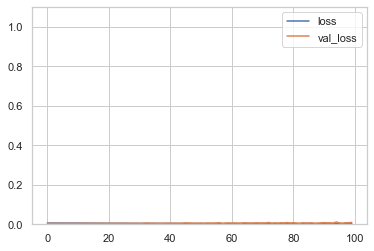

Model Evalution Score
30/30 [==============================] - 0s 2ms/step - loss: 0.0085
0.008527432568371296


In [384]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1.1) # set the y range to [0,1]
plt.show()
print('Model Evalution Score')
print(model.evaluate(X_test, y_test))

In [385]:
#model.save(r"..\models\model.h5")

In [386]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [387]:
X_train = sales[: int(len(sales)*0.8)].sales_norm
X_train

X_test = sales[int(len(sales)*0.8):].sales_norm
X_test

3808    0.025716
3809    0.039743
3810    0.080655
3811    0.051432
3812    0.025716
          ...   
4756    0.031444
4757    0.039743
4758    0.039743
4759    0.063004
4760    0.031444
Name: sales_norm, Length: 953, dtype: float64

In [388]:
trainPredict = trainPredict.flatten().tolist()
testPredict = testPredict.flatten().tolist()

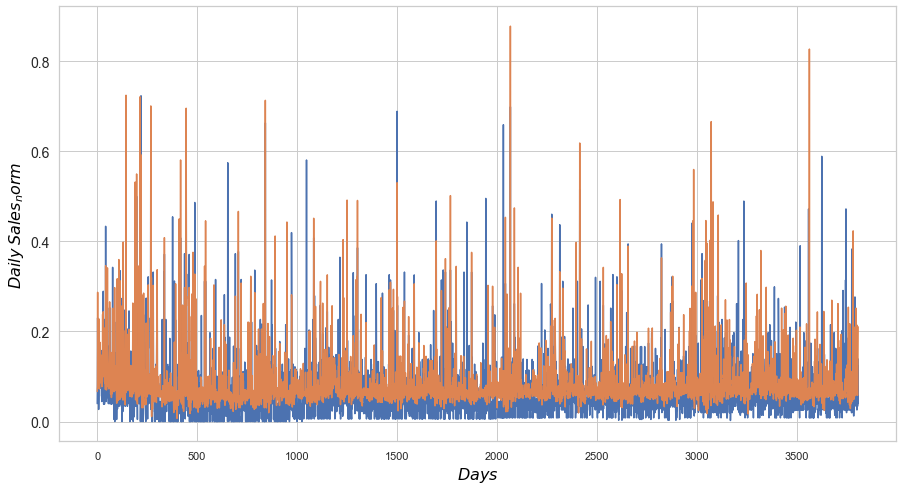

In [389]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
sns.lineplot(x = np.arange(int(len(sales)*0.8)), y = sales[: int(len(sales)*0.8)].sales_norm, ax = ax)  
sns.lineplot(x = np.arange(int(len(sales)*0.8)), y =trainPredict , ax = ax)
plt.xlabel(r'$Days$', fontdict = font)
plt.ylabel(r'$Daily _ Sales_norm$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

In [390]:
model.save(r'.\models\model_100_2.h5')

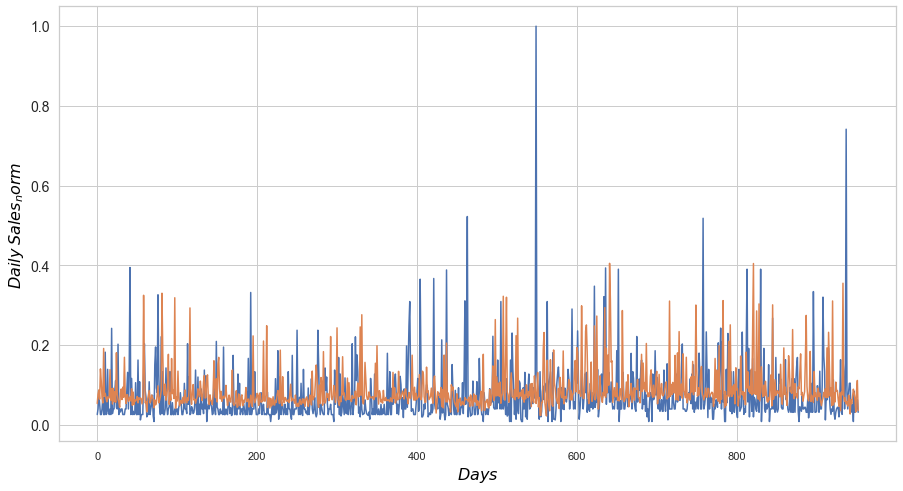

In [391]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
sns.lineplot(x = np.arange(int(len(sales))- int(len(sales)*0.8)), y = sales[int(len(sales)*0.8):].sales_norm, ax = ax) 
sns.lineplot(x = np.arange(int(len(sales))- int(len(sales)*0.8)), y = testPredict, ax = ax)
plt.xlabel(r'$Days$', fontdict = font)
plt.ylabel(r'$Daily _ Sales_norm$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

In [392]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.09 RMSE
